In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

df = pd.read_csv("AmesHousing.csv", sep="\t")
pd.options.future.infer_string = True

print("shape:", df.shape)
print(df.head(10))
print(df.dtypes.value_counts())



shape: (2930, 82)
   Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   
5      6  527105030           60        RL          78.0      9978   Pave   
6      7  527127150          120        RL          41.0      4920   Pave   
7      8  527145080          120        RL          43.0      5005   Pave   
8      9  527146030          120        RL          39.0      5389   Pave   
9     10  527162130           60        RL          60.0      7500   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   str    
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   str    
 7   Alley            198 non-null    str    
 8   Lot Shape        2930 non-null   str    
 9   Land Contour     2930 non-null   str    
 10  Utilities        2930 non-null   str    
 11  Lot Config       2930 non-null   str    
 12  Land Slope       2930 non-null   str    
 13  Neighborhood     2930 non-null   str    
 14  Condition 1      2930 non-null   str    
 15  Condition 2      2930 non-null   str    
 16  Bldg Type        2930 non-null   str    
 17  House Style   

In [82]:
df.dtypes.value_counts()

str        43
int64      28
float64    11
Name: count, dtype: int64

In [83]:
df.duplicated().any()

np.False_

In [84]:
missing = df.isnull().sum().sort_values(ascending=False).head(30)
print(missing)

Pool QC           2917
Misc Feature      2824
Alley             2732
Fence             2358
Mas Vnr Type      1775
Fireplace Qu      1422
Lot Frontage       490
Garage Qual        159
Garage Yr Blt      159
Garage Cond        159
Garage Finish      159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
Bsmt Qual           80
Bsmt Cond           80
BsmtFin Type 1      80
Mas Vnr Area        23
Bsmt Full Bath       2
Bsmt Half Bath       2
Total Bsmt SF        1
BsmtFin SF 1         1
BsmtFin SF 2         1
Garage Area          1
Garage Cars          1
Bsmt Unf SF          1
Electrical           1
Lot Shape            0
Street               0
Lot Area             0
dtype: int64


In [85]:
print(df.columns)

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

In [86]:
df.dtypes

Order               int64
PID                 int64
MS SubClass         int64
MS Zoning             str
Lot Frontage      float64
                   ...   
Mo Sold             int64
Yr Sold             int64
Sale Type             str
Sale Condition        str
SalePrice           int64
Length: 82, dtype: object

Here NA means “not present” (eg no basement). Wr convert to explicit labels to keep that signal.

In [87]:
# 2.1) dicționar valori "nu exista"
na_none_map = {
    'Alley': 'NoAlley',
    'Bsmt Qual': 'NoBasement',
    'Bsmt Cond': 'NoBasement',
    'Bsmt Exposure': 'NoBasement',
    'BsmtFin Type 1': 'NoBasement',
    'BsmtFin Type 2': 'NoBasement',
    'Fireplace Qu': 'NoFireplace',
    'Garage Type': 'NoGarage',
    'Garage Finish': 'NoGarage',
    'Garage Qual': 'NoGarage',
    'Garage Cond': 'NoGarage',
    'Pool QC': 'NoPool',
    'Fence': 'NoFence',
    'Misc Feature': 'NoFeature'
}

for col, val in na_none_map.items():
    if col in df.columns:
        df[col] = df[col].replace('NA', val).fillna(val)

print("after NA")


after NA


If there’s basement area, exposure can’t be “NoBasement”. We correct those few rows.

In [88]:
# detectez daca exista subsol din arii
has_bsmt_area = (df[['BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF']].fillna(0).sum(axis=1) > 0)

# daca are arie, dar 'Bsmt Exposure' este 'NoBasement' => pun 'No'
bad_expo = has_bsmt_area & (df['Bsmt Exposure'] == 'NoBasement')
df['Fix_BsmtExposure'] = 0
df.loc[bad_expo, 'Bsmt Exposure'] = 'No'
df.loc[bad_expo, 'Fix_BsmtExposure'] = 1

print("fix basement exposure:", df['Fix_BsmtExposure'].sum(), "rows")


fix basement exposure: 3 rows


For homes with a garage, fix labels via type-mode and fill area/cars by type medians.

In [89]:
# rows that have garage info
g_has = (df['Garage Type'] != 'NoGarage') | (df['Garage Area'].fillna(0) > 0) | (df['Garage Cars'].fillna(0) > 0)

def simple_mode(s):
    m = s.mode(dropna=True)
    return m.iloc[0] if len(m) else np.nan

label_cols = ['Garage Finish','Garage Qual','Garage Cond']

label_cols = ['Garage Finish','Garage Qual','Garage Cond']
modes_by_type = df[g_has].groupby('Garage Type')[label_cols].agg(simple_mode)

# median for numeric columns
med_area_by_type = df[g_has].groupby('Garage Type')['Garage Area'].median()
med_cars_by_type = df[g_has].groupby('Garage Type')['Garage Cars'].median()

# repair missing labels based on Garage Type
df['Fix_Garage'] = 0
need_fix = g_has & (
    (df['Garage Finish'] == 'NoGarage') |
    (df['Garage Qual']   == 'NoGarage') |
    (df['Garage Cond']   == 'NoGarage')
)

for c in label_cols:
    mask = need_fix & ((df[c] == 'NoGarage') | df[c].isna())
    fill_vals = df.loc[mask, 'Garage Type'].map(modes_by_type[c])
    df.loc[mask, c] = fill_vals
    df.loc[mask, 'Fix_Garage'] = 1

# complete numeric missing values based on Garage Type
mask_area_na = g_has & df['Garage Area'].isna()
mask_cars_na = g_has & df['Garage Cars'].isna()
df.loc[mask_area_na, 'Garage Area'] = df.loc[mask_area_na, 'Garage Type'].map(med_area_by_type)
df.loc[mask_cars_na, 'Garage Cars'] = df.loc[mask_cars_na, 'Garage Type'].map(med_cars_by_type)
df.loc[mask_area_na | mask_cars_na, 'Fix_Garage'] = 1

print("fix garage:", df['Fix_Garage'].sum(), "rows")


fix garage: 2 rows


Area=0 ⇒ type=None. If area>0 and type missing, impute type by neighborhood mode.

In [90]:
# 4 cases
area = df['Mas Vnr Area']
typ  = df['Mas Vnr Type']

m_area0 = area.fillna(0) == 0
m_area_pos = area.fillna(0) > 0
m_type_none = typ == 'None'
m_type_na = typ.isna()
m_type_notnone = ~(m_type_none | m_type_na)

# easy cases first
df.loc[m_type_na & m_area0, 'Mas Vnr Type'] = 'None'
df.loc[m_type_notnone & m_area0, 'Mas Vnr Type'] = 'None'

# impute remaining missing types by neighborhood mode, fallback global mode
global_mode = df['Mas Vnr Type'].dropna().mode()
global_mode = global_mode.iloc[0] if len(global_mode) else 'BrkFace'

if 'Neighborhood' in df.columns:
    ref = df[m_area_pos & ~m_type_none & ~m_type_na]
    nb_mode = ref.groupby('Neighborhood')['Mas Vnr Type'].agg(simple_mode)
    mask_A = m_type_none & m_area_pos
    mask_D = m_type_na   & m_area_pos
    df.loc[mask_A, 'Mas Vnr Type'] = df.loc[mask_A, 'Neighborhood'].map(nb_mode).fillna(global_mode)
    df.loc[mask_D, 'Mas Vnr Type'] = df.loc[mask_D, 'Neighborhood'].map(nb_mode).fillna(global_mode)
else:
    df.loc[m_area_pos & (m_type_none | m_type_na), 'Mas Vnr Type'] = global_mode

print("masonry veneer ok")


masonry veneer ok


Force Total Bsmt SF = sum(parts); if no basement, set all basement SF to 0.


In [91]:
parts = ['BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF']
total = 'Total Bsmt SF'

sum_parts = df[parts].fillna(0).sum(axis=1)
all_parts_na = df[parts].isna().all(axis=1)
total_na = df[total].isna()

# set basement area to 0 where no basement
mask_true_mismatch = (~all_parts_na) & (~total_na) & (df[total] != sum_parts)
mask_total_missing = (~all_parts_na) & total_na
df.loc[mask_true_mismatch, total] = sum_parts[mask_true_mismatch]
df.loc[mask_total_missing, total] = sum_parts[mask_total_missing]

# if just partial parts missing, fill with 0
mask_parts_missing = all_parts_na & (~total_na)
for c in parts:
    df.loc[mask_parts_missing, c] = df.loc[mask_parts_missing, c].fillna(0)

# if all are missing and Bsmt Qual = NoBasement, set all to 0
mask_all_missing = all_parts_na & total_na & (df['Bsmt Qual'] == 'NoBasement')
for c in parts + [total]:
    df.loc[mask_all_missing, c] = 0

print("basement identities ok")


basement identities ok


Keep rows with sensible chronology (sold after built/remod; garage year plausible).


In [92]:
# selling year >= built year and remodel year
mask_time_ok = (df['Yr Sold'] >= df['Year Built']) & (df['Yr Sold'] >= df['Year Remod/Add'])
df = df[mask_time_ok].copy()

# remodel year >= built year
df = df[df['Year Remod/Add'] >= df['Year Built']].copy()

# the year of the garage construction is either missing or between 1880 and Yr Sold + 1
mask_gyear_ok = (~df['Garage Yr Blt'].notna()) | (
    (df['Garage Yr Blt'] >= 1880) & (df['Garage Yr Blt'] <= (df['Yr Sold'] + 1))
)
df = df[mask_gyear_ok].copy()

print("time checks ok; shape:", df.shape)


time checks ok; shape: (2925, 84)


Create clean 0/1 features (pool, fire, AC, fence, garage) + a simple amenities count.

In [93]:
# 8.1) flags
df['HasPool']   = (df['Pool Area'] > 0).astype(int)
df['HasFire']   = (df['Fireplaces'] > 0).astype(int)
df['HasAC']     = (df['Central Air'] == 'Y').astype(int)
df['HasFence']  = (df['Fence'] != 'NoFence').astype(int)
df['HasGarage'] = (df['Garage Cars'].fillna(0) > 0).astype(int)
df['AmenitiesCount'] = df[['HasPool','HasFire','HasAC','HasFence','HasGarage']].sum(axis=1)

print("flags ok")


flags ok


Lot Frontage by neighborhood median; numeric “not present” → 0 (+indicator); rest → global median.

In [94]:
# 9.1) lot frontage by neighborhood median
if 'Lot Frontage' in df.columns and 'Neighborhood' in df.columns:
    med_glob = df['Lot Frontage'].median()
    med_nb = df.groupby('Neighborhood')['Lot Frontage'].transform('median')
    df['Lot Frontage'] = df['Lot Frontage'].fillna(med_nb).fillna(med_glob)


# 9.2) NaN for numeric that mean "not present" -> 0 + indicator
exist_num = [
    'Garage Yr Blt','Garage Area','Garage Cars',
    'BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF',
    'Bsmt Full Bath','Bsmt Half Bath','Pool Area','Mas Vnr Area'
]
for c in exist_num:
    if c in df.columns:
        df[f'{c}_was_missing'] = df[c].isna().astype(int)
        df[c] = df[c].fillna(0)

# the rest of numeric columns -> global median
num_cols_all = df.select_dtypes(include=[np.number]).columns
for c in num_cols_all:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

print("all ok")


all ok


Drop features with low variance / redundant / noisy.
Utilities → almost all “AllPub”; no variance → useless.
Street → nearly all “Paved”; constant feature.
Condition 2 → 99% “Norm”; no signal.
Roof Matl → dominated by “CompShg”; low diversity.
Heating → almost all “GasA”; no predictive value.
Pool QC → too many NaNs; info kept via HasPool.
Misc Feature → rare values, mostly missing; noisy.
Garage Cond → overlaps with Garage Qual; redundant.
Fix_BsmtExposure, Fix_Garage → internal audit flags; not for modeling.

In [95]:
# todo drop PID','Order' after plot

to_drop = [
    'Utilities','Street','Condition 2','Roof Matl','Heating',
    'Pool QC','Misc Feature',
    'Garage Cond',
    'Fix_Garage','Fix_BsmtExposure'
]
keep = [c for c in to_drop if c in df.columns]
df = df.drop(columns=keep).copy()

print("drop ok. shape:", df.shape)


drop ok. shape: (2925, 91)


In [96]:
# Encoding categoricals
#  definire ordine pentru variabilele ordinale (cu denumirile exacte din dataframe)

ord_orders = {
    'Exter Qual':    ['Po','Fa','TA','Gd','Ex'],
    'Exter Cond':    ['Po','Fa','TA','Gd','Ex'],

    'Bsmt Qual':     ['NoBasement','Po','Fa','TA','Gd','Ex'],
    'Bsmt Cond':     ['NoBasement','Po','Fa','TA','Gd','Ex'],
    'Bsmt Exposure': ['NoBasement','No','Mn','Av','Gd'],
    'BsmtFin Type 1':['NoBasement','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
    'BsmtFin Type 2':['NoBasement','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
    'Heating QC':    ['Po','Fa','TA','Gd','Ex'],
    'Electrical':    ['FuseP','FuseF','Mix','FuseA','SBrkr'],
    'Kitchen Qual':  ['Po','Fa','TA','Gd','Ex'],
    'Fireplace Qu':  ['NoFireplace','Po','Fa','TA','Gd','Ex'],
    'Garage Finish': ['NoGarage','Unf','RFn','Fin'],
    'Garage Qual':   ['NoGarage','Po','Fa','TA','Gd','Ex'],
    'Paved Drive':   ['N','P','Y'],
    'Lot Shape':     ['IR3','IR2','IR1','Reg'],
    'Land Slope':    ['Sev','Mod','Gtl'],

    # 'Functional':    ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],
}

# mapare efectiva la coduri (−1 -> NaN)
for col, order in ord_orders.items():
    if col in df.columns:
        cat = pd.Categorical(df[col], categories=order, ordered=True)
        s = pd.Series(cat.codes, index=df.index).astype('float64')  # array -> Series
        s[s == -1] = np.nan                                        # valori în afara listelor -> NaN
        df[col] = s

#  One-Hot Encoding pe nominale “pure”
ohe_cols = [
    'MS SubClass','MS Zoning','Neighborhood','Condition 1','Bldg Type',
    'House Style','Roof Style','Exterior 1st','Exterior 2nd','Mas Vnr Type',
    'Foundation','Lot Config','Land Contour','Garage Type','Sale Type','Sale Condition'
]
ohe_cols = [c for c in ohe_cols if c in df.columns]

# construiesc X și y
y = df['SalePrice'].astype(float)
X = pd.get_dummies(
    df.drop(columns=['SalePrice']),
    columns=ohe_cols,
    drop_first=False,
    dtype=int
)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (2925, 229)
y shape: (2925,)


P99 area: 2872.0 | P99 price: 456784.0 | nr out. price: 30


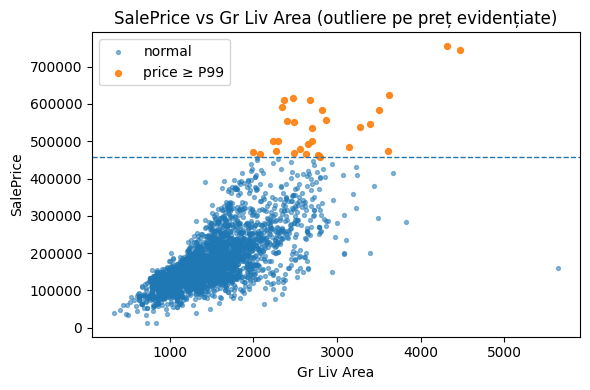

In [97]:
# 12.1) prag P99 pentru Gr Liv Area si SalePrice
p99_area = df['Gr Liv Area'].quantile(0.99)
p99_price = df['SalePrice'].quantile(0.99)

# outliere de preț (sus)
mask_hp = df['SalePrice'] > p99_price
print("P99 area:", round(p99_area,1), "| P99 price:", round(p99_price,0), "| nr out. price:", int(mask_hp.sum()))

# scatter cu outlierele colorate diferit
plt.figure(figsize=(6,4))
plt.scatter(df.loc[~mask_hp,'Gr Liv Area'], df.loc[~mask_hp,'SalePrice'], s=8, alpha=0.5, label='normal')
plt.scatter(df.loc[mask_hp,'Gr Liv Area'], df.loc[mask_hp,'SalePrice'], s=18, alpha=0.9, label='price ≥ P99')
plt.axhline(p99_price, linestyle='--', linewidth=1)
plt.title("SalePrice vs Gr Liv Area (outliere pe preț evidențiate)")
plt.xlabel("Gr Liv Area")
plt.ylabel("SalePrice")
plt.legend()
plt.tight_layout()
plt.show()


In [98]:
#todo  in progress - outlier handling
df['HasPool']   = (df['Pool Area'].fillna(0) > 0).astype(int)
df['HasFire']   = (df['Fireplaces'].fillna(0) > 0).astype(int)
df['HasAC']     = (df['Central Air'].replace({'Y':1,'N':0}).fillna(0) == 1).astype(int)
df['HasFence']  = (df['Fence'].fillna('NoFence') != 'NoFence').astype(int)
df['HasGarage'] = (df['Garage Cars'].fillna(0) > 0).astype(int)

df['AmenitiesCount'] = df[['HasPool','HasFire','HasAC','HasFence','HasGarage']].sum(axis=1)


C:\Users\scoti\AppData\Local\Temp\ipykernel_20572\2203655781.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['HasAC']     = (df['Central Air'].replace({'Y':1,'N':0}).fillna(0) == 1).astype(int)


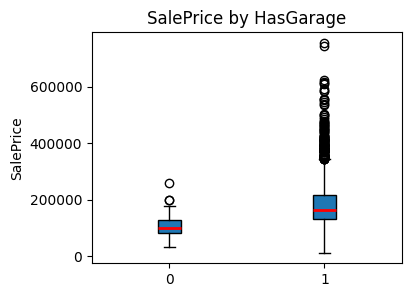

In [99]:
d0 = df.loc[df['HasGarage']==0, 'SalePrice'].dropna()
d1 = df.loc[df['HasGarage']==1, 'SalePrice'].dropna()
plt.figure(figsize=(4,3))
plt.boxplot([d0, d1], tick_labels=['0','1'], patch_artist=True, medianprops=dict(color='red', linewidth=2))
plt.title("SalePrice by HasGarage")
plt.ylabel("SalePrice")
plt.show()


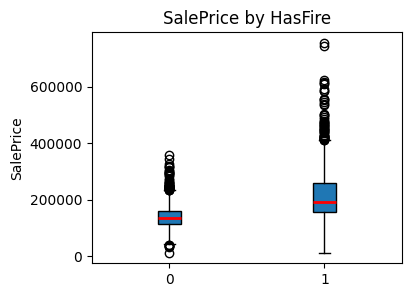

In [100]:
d0 = df.loc[df['HasFire']==0, 'SalePrice'].dropna()
d1 = df.loc[df['HasFire']==1, 'SalePrice'].dropna()
plt.figure(figsize=(4,3))
plt.boxplot([d0, d1], tick_labels=['0','1'], patch_artist=True, medianprops=dict(color='red', linewidth=2))
plt.title("SalePrice by HasFire")
plt.ylabel("SalePrice")
plt.show()


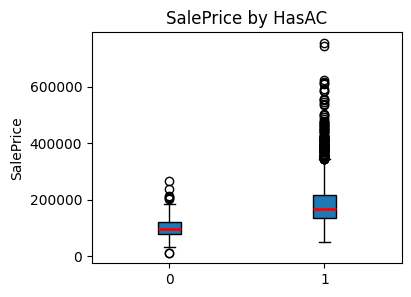

In [101]:
d0 = df.loc[df['HasAC']==0, 'SalePrice'].dropna()
d1 = df.loc[df['HasAC']==1, 'SalePrice'].dropna()
plt.figure(figsize=(4,3))
plt.boxplot([d0, d1], tick_labels=['0','1'], patch_artist=True, medianprops=dict(color='red', linewidth=2))
plt.title("SalePrice by HasAC")
plt.ylabel("SalePrice")
plt.show()


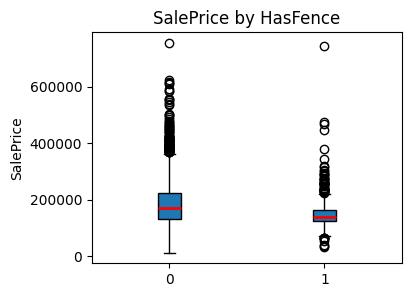

In [102]:
d0 = df.loc[df['HasFence']==0, 'SalePrice'].dropna()
d1 = df.loc[df['HasFence']==1, 'SalePrice'].dropna()
plt.figure(figsize=(4,3))
plt.boxplot([d0, d1], tick_labels=['0','1'], patch_artist=True, medianprops=dict(color='red', linewidth=2))
plt.title("SalePrice by HasFence")
plt.ylabel("SalePrice")
plt.show()


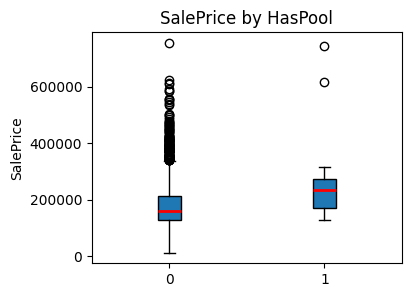

In [103]:
d0 = df.loc[df['HasPool']==0, 'SalePrice'].dropna()
d1 = df.loc[df['HasPool']==1, 'SalePrice'].dropna()
plt.figure(figsize=(4,3))
plt.boxplot([d0, d1], tick_labels=['0','1'], patch_artist=True, medianprops=dict(color='red', linewidth=2))
plt.title("SalePrice by HasPool")
plt.ylabel("SalePrice")
plt.show()


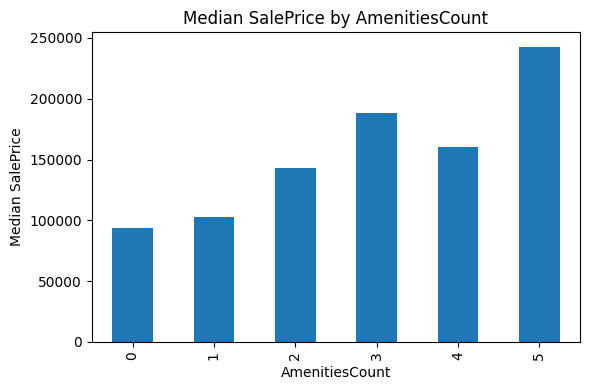

In [104]:
ax = (df.groupby('AmenitiesCount')['SalePrice']
        .median()
        .plot(kind='bar', figsize=(6,4), title='Median SalePrice by AmenitiesCount'))
ax.set_ylabel("Median SalePrice")
plt.tight_layout()
plt.show()


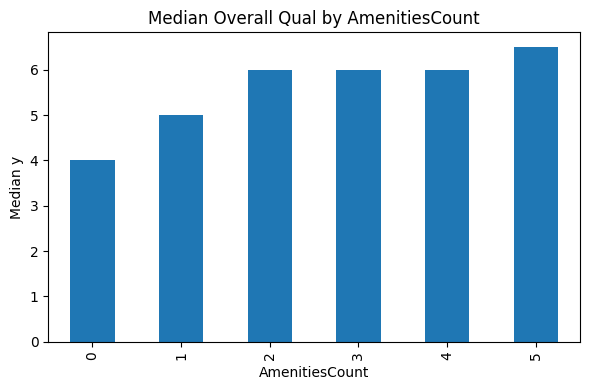

In [105]:
ax = (df.groupby('AmenitiesCount')['Overall Qual']
        .median()
        .sort_index()
        .plot(kind='bar', figsize=(6,4), title='Median Overall Qual by AmenitiesCount'))
ax.set_ylabel("Median y")
plt.tight_layout(); plt.show()


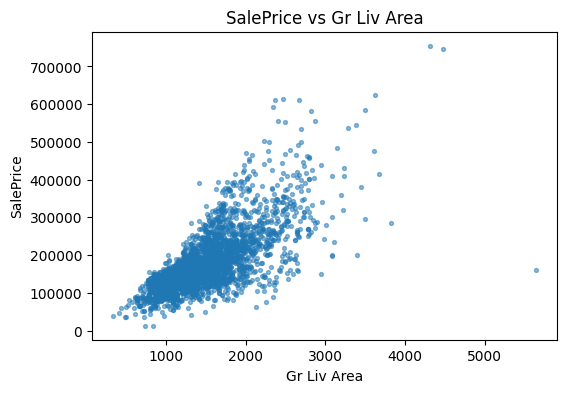

In [106]:
plt.figure(figsize=(6,4))
plt.scatter(df['Gr Liv Area'], df['SalePrice'], s=8, alpha=0.5)
plt.title("SalePrice vs Gr Liv Area")
plt.xlabel("Gr Liv Area")
plt.ylabel("SalePrice")
plt.show()


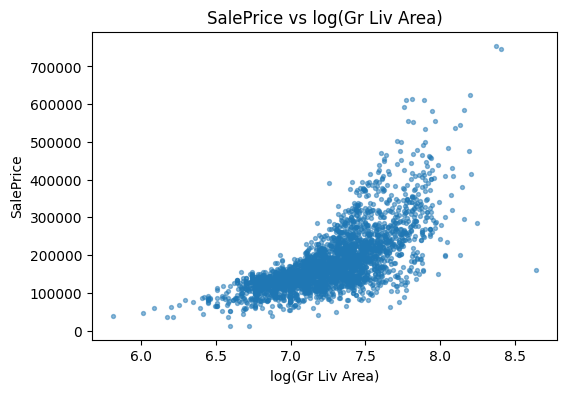

In [107]:
x = np.log1p(df['Gr Liv Area'].clip(lower=0))
y = df['SalePrice'].astype(float)
plt.figure(figsize=(6,4))
plt.scatter(x, y, s=8, alpha=0.5)
plt.title("SalePrice vs log(Gr Liv Area)")
plt.xlabel("log(Gr Liv Area)")
plt.ylabel("SalePrice")
plt.show()


Check last numerical for outliers

In [108]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != 'SalePrice']
print("Num cols:", len(num_cols))

Num cols: 71


In [109]:
def iqr_bounds(s, k=1.5):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    low  = q1 - k*iqr
    high = q3 + k*iqr
    return low, high

rows = []
for c in num_cols:
    s = df[c].dropna().astype(float)
    if s.empty:
        continue
    lo, hi = iqr_bounds(s, 1.5)
    out_mask = (df[c] < lo) | (df[c] > hi)
    rows.append({
        "col": c,
        "n": int(df[c].notna().sum()),
        "outliers": int(out_mask.sum()),
        "pct_out": 100 * out_mask.mean(),
        "min": float(s.min()), "q1": float(s.quantile(0.25)),
        "median": float(s.median()), "q3": float(s.quantile(0.75)),
        "max": float(s.max()),
        "iqr_lo": float(lo), "iqr_hi": float(hi),
        "p01": float(s.quantile(0.01)), "p99": float(s.quantile(0.99)),
    })

out_summary = pd.DataFrame(rows).sort_values("pct_out", ascending=False)
print(out_summary.head(15)[["col","n","outliers","pct_out","min","median","max","iqr_lo","iqr_hi","p99"]].round(2))


               col     n  outliers  pct_out   min  median     max  iqr_lo  \
57        HasFence  2925       572    19.56   0.0     0.0     1.0     0.0   
47  Enclosed Porch  2925       459    15.69   0.0     0.0  1012.0     0.0   
19  BsmtFin Type 2  2925       431    14.74   0.0     1.0     6.0     1.0   
13      Exter Cond  2925       381    13.03   0.0     2.0     4.0     2.0   
20    BsmtFin SF 2  2925       351    12.00   0.0     0.0  1526.0     0.0   
15       Bsmt Cond  2925       314    10.74   0.0     3.0     5.0     3.0   
43     Garage Qual  2925       313    10.70   0.0     3.0     5.0     3.0   
16   Bsmt Exposure  2925       282     9.64   0.0     1.0     4.0    -0.5   
44     Paved Drive  2925       278     9.50   0.0     2.0     2.0     2.0   
49    Screen Porch  2925       256     8.75   0.0     0.0   576.0     0.0   
8     Overall Cond  2925       252     8.62   1.0     5.0     9.0     3.5   
24      Electrical  2924       247     8.44   0.0     4.0     4.0     4.0   

In [110]:
for c in num_cols:
    s = df[c].astype(float)
    lo, hi = iqr_bounds(s.dropna(), 1.5)
    df[f"OUT_{c}"] = ((s < lo) | (s > hi)).astype(int)

# vezi top coloane dupa % outliere
flag_cols = [c for c in df.columns if c.startswith("OUT_")]
out_rates = df[flag_cols].mean().sort_values(ascending=False) * 100
print(out_rates.head(15).round(2))


OUT_HasFence          19.56
OUT_Enclosed Porch    15.69
OUT_BsmtFin Type 2    14.74
OUT_Exter Cond        13.03
OUT_BsmtFin SF 2      12.00
OUT_Bsmt Cond         10.74
OUT_Garage Qual       10.70
OUT_Bsmt Exposure      9.64
OUT_Paved Drive        9.50
OUT_Screen Porch       8.75
OUT_Overall Cond       8.62
OUT_Electrical         8.44
OUT_MS SubClass        7.11
OUT_Lot Frontage       6.94
OUT_Mas Vnr Area       6.91
dtype: float64


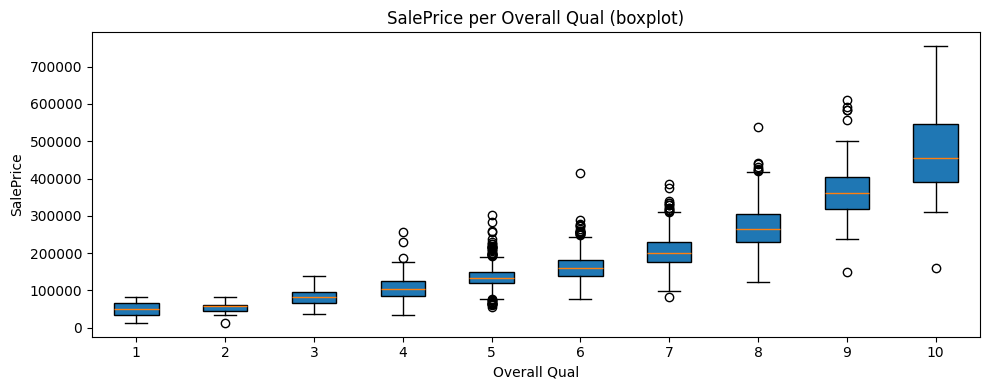

In [111]:
plt.figure(figsize=(10,4))
data = [df.loc[df['Overall Qual']==k, 'SalePrice'] for k in sorted(df['Overall Qual'].unique())]
plt.boxplot(data, tick_labels=sorted(df['Overall Qual'].unique()), patch_artist=True)
plt.title("SalePrice per Overall Qual (boxplot)")
plt.xlabel("Overall Qual")
plt.ylabel("SalePrice")
plt.tight_layout()
plt.show()


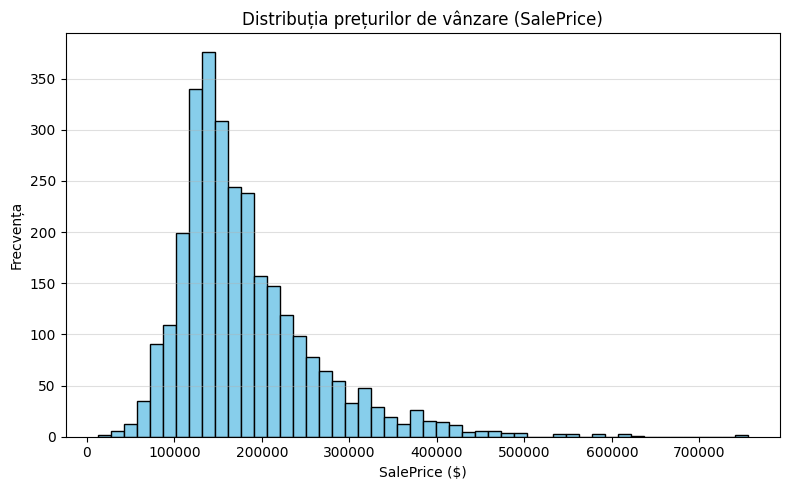

In [112]:
plt.figure(figsize=(8,5))
plt.hist(df['SalePrice'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribuția prețurilor de vânzare (SalePrice)")
plt.xlabel("SalePrice ($)")
plt.ylabel("Frecvența")
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()


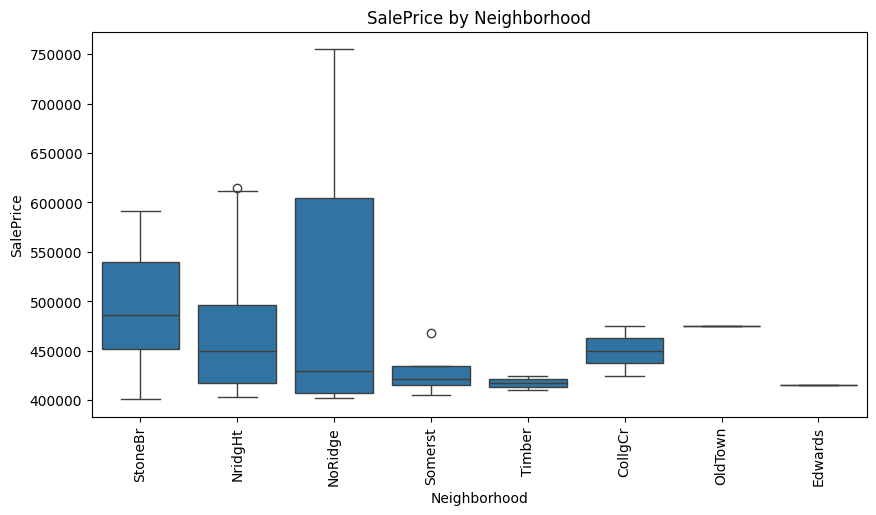

In [113]:
df_filtered = df[df['SalePrice'] > 400000]

plt.figure(figsize=(10,5))
sns.boxplot(x='Neighborhood', y='SalePrice', data=df_filtered)
plt.xticks(rotation=90)
plt.title("SalePrice by Neighborhood")
plt.show()


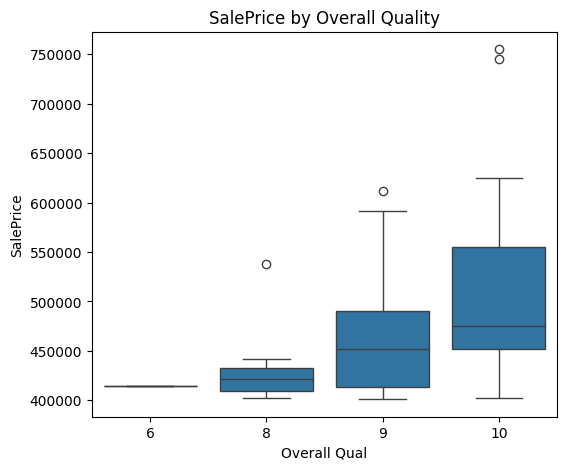

In [114]:
plt.figure(figsize=(6,5))
sns.boxplot(x='Overall Qual', y='SalePrice', data=df_filtered)
plt.title("SalePrice by Overall Quality")
plt.show()

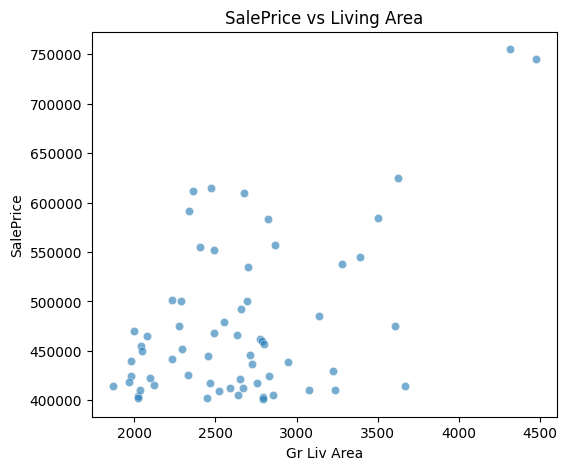

In [115]:
plt.figure(figsize=(6,5))
sns.scatterplot(x='Gr Liv Area', y='SalePrice', data=df_filtered, alpha=0.6)
plt.title("SalePrice vs Living Area")
plt.show()

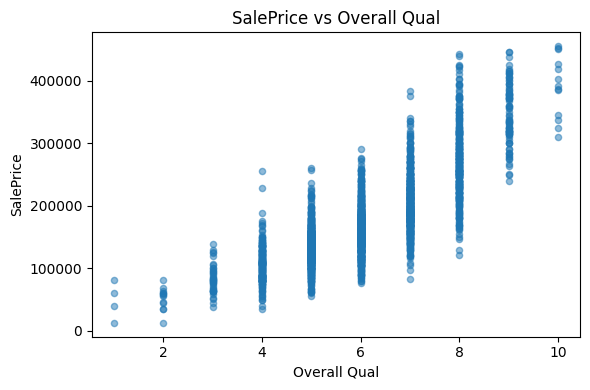

In [116]:
df = df[(df['Gr Liv Area'] < p99_area) & (df['SalePrice'] < p99_price)]
#regresie
plt.figure(figsize=(6,4))
plt.scatter(df['Overall Qual'], df['SalePrice'], alpha=0.5, s=20)
plt.title("SalePrice vs Overall Qual")
plt.xlabel("Overall Qual")
plt.ylabel("SalePrice")
plt.tight_layout()
plt.show()

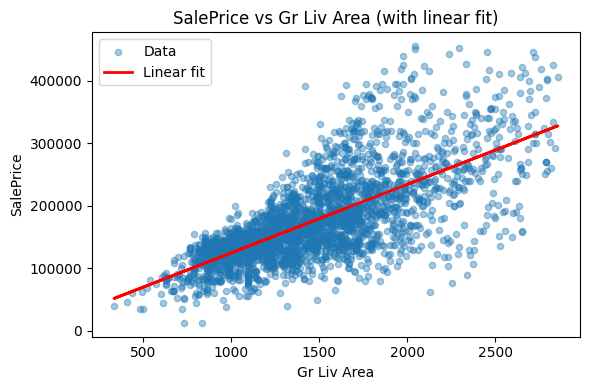

In [121]:
import matplotlib.pyplot as plt
import numpy as np

# thresholds from the current data (TRAIN ONLY to avoid leakage!)
p_lo_price, p_hi_price = df['SalePrice'].quantile([0.01, 0.99])
p_lo_area,  p_hi_area  = df['Gr Liv Area'].quantile([0.01, 0.99])



x = df['Gr Liv Area']
y = df['SalePrice']

# Fit linear trend
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)

plt.figure(figsize=(6,4))
plt.scatter(x, y, alpha=0.4, s=20, label="Data")
plt.plot(x, poly1d_fn(x), color='red', linewidth=2, label="Linear fit")
plt.title("SalePrice vs Gr Liv Area (with linear fit)")
plt.xlabel("Gr Liv Area")
plt.ylabel("SalePrice")
plt.legend()
plt.tight_layout()
plt.show()


Kept 2299 / 2872 rows (80.0% within q=0.1–0.9)


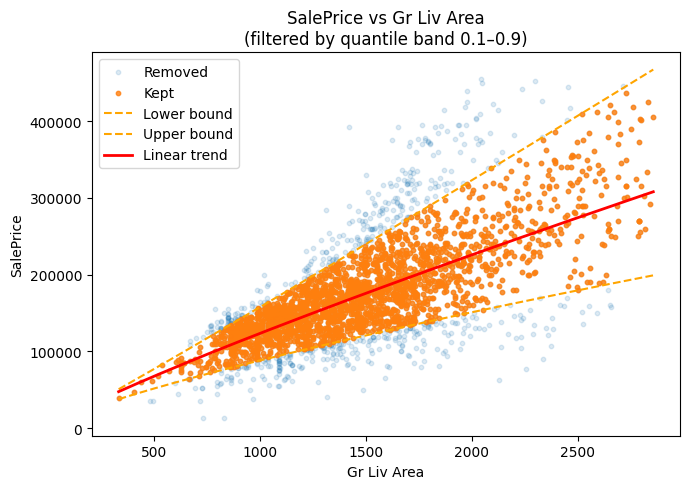

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import QuantileRegressor

# --- prepare log-transformed data
x = np.log1p(df['Gr Liv Area'].values.reshape(-1, 1))
y = np.log1p(df['SalePrice'].values)

# --- fit quantile regression models for lower and upper bounds
low_q, high_q = 0.1, 0.9

qr_low  = QuantileRegressor(quantile=low_q, alpha=0).fit(x, y)
qr_high = QuantileRegressor(quantile=high_q, alpha=0).fit(x, y)

# --- predicted band for each point
y_low  = qr_low.predict(x)
y_high = qr_high.predict(x)

# --- keep only the points that lie within the band
mask_in = (y >= y_low) & (y <= y_high)
df_band = df[mask_in].copy()

print(f"Kept {mask_in.sum()} / {len(df)} rows "
      f"({mask_in.mean()*100:.1f}% within q={low_q}–{high_q})")

# --- Fit linear trend *on filtered data*
x_fit = np.log1p(df_band['Gr Liv Area'].values)
y_fit = np.log1p(df_band['SalePrice'].values)
coef = np.polyfit(x_fit, y_fit, 1)
poly1d_fn = np.poly1d(coef)

# --- visualize result
plt.figure(figsize=(7,5))
plt.scatter(df['Gr Liv Area'], df['SalePrice'], s=10, alpha=0.15, label='Removed')
plt.scatter(df_band['Gr Liv Area'], df_band['SalePrice'], s=10, alpha=0.8, label='Kept')

# --- Draw quantile bounds and linear trend (convert back from log scale)
x_line = np.linspace(df['Gr Liv Area'].min(), df['Gr Liv Area'].max(), 200)
x_log = np.log1p(x_line).reshape(-1, 1)

plt.plot(x_line, np.expm1(qr_low.predict(x_log)), color='orange', linestyle='--', label='Lower bound')
plt.plot(x_line, np.expm1(qr_high.predict(x_log)), color='orange', linestyle='--', label='Upper bound')
plt.plot(x_line, np.expm1(poly1d_fn(np.log1p(x_line))), color='red', linewidth=2, label='Linear trend')

plt.title(f"SalePrice vs Gr Liv Area\n(filtered by quantile band {low_q}–{high_q})")
plt.xlabel("Gr Liv Area")
plt.ylabel("SalePrice")
plt.legend()
plt.tight_layout()
plt.show()


In [132]:
df_band.shape

(2299, 162)

In [134]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge  # or LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# --- 1) X / y from the kept data
df_train = df_band.copy()  # <- your inlier-only DataFrame
y = df_train['SalePrice'].astype(float)
X = df_train.drop(columns=['SalePrice', 'Order', 'PID'], errors='ignore')  # drop IDs if present

# --- 2) Column splits
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# --- 3) Preprocessing pipelines
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', ohe)
])

pre = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
], remainder='drop')

# --- 4) Model (Ridge) with log target for better fit
reg = Pipeline([('pre', pre), ('ridge', Ridge(alpha=1.0))])
model = TransformedTargetRegressor(
    regressor=reg, func=np.log1p, inverse_func=np.expm1
)

# --- 5) Train / test split + fit
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(Xtr, ytr)

# --- 6) Evaluation
pred_tr = model.predict(Xtr)
pred_te = model.predict(Xte)

import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def metrics(y_true, y_pred, tag):
    mse  = mean_squared_error(y_true, y_pred)      # always returns MSE
    rmse = np.sqrt(mse)                            # <- compute RMSE manually
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{tag} -> R2: {r2:.3f} | RMSE: {rmse:,.0f} | MAE: {mae:,.0f}")


metrics(ytr, pred_tr, "Train")
metrics(yte, pred_te, "Test")

# --- 7) Quick peek at predictions
peek = Xte.head(5)
print("\nPredicted vs actual (first 5 test rows):")
print(np.column_stack([model.predict(peek), yte.loc[peek.index].values]))


Train -> R2: 0.952 | RMSE: 12,907 | MAE: 9,422
Test -> R2: 0.926 | RMSE: 14,709 | MAE: 10,346

Predicted vs actual (first 5 test rows):
[[216762.13888759 235000.        ]
 [164707.33171481 170000.        ]
 [292518.44397454 318000.        ]
 [142584.3362096  147500.        ]
 [188869.0600054  154000.        ]]
